In [214]:
# -*- coding: utf-8 -*-
from __future__ import print_function

import numpy as np
np.random.seed(1335)  # for reproducibility
np.set_printoptions(precision=5, suppress=True, linewidth=150)

import pandas as pd
import backtest as twp
from matplotlib import pyplot as plt
from sklearn import metrics, preprocessing
from talib.abstract import *
from sklearn.externals import joblib
import os.path


import quandl

#Load data
def read_convert_data(symbol='GPC'):
    fname = 'data/' + symbol + '_1day.pkl'
    if (os.path.isfile(fname)):
        return
    quandl.ApiConfig.api_key = "GNPQiKazcmAssCAzLaw1"
    prices = quandl.get('WIKI/' + symbol)
    prices.to_pickle(fname) # a /data folder must exist
    return

def load_data(test=False, symbol='GPC', max_data=2000, test_percent=0.15):
    prices = pd.read_pickle('data/' + symbol + '_1day.pkl')
    prices.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume (BTC)': 'volume'}, inplace=True)
    
    #prices = np.sin(np.arange(200)/30.0) #sine prices
    
    total = max_data if max_data < prices.shape[0] else prices.shape[0]
    end = int(total * test_percent)

    
    x_train = prices.iloc[-total:-end,]
    x_test= prices.iloc[-total:,]
    if test:
        return x_test
    else:
        return x_train

#Initialize first state, all items are placed deterministically
def init_state(indata, test=False):
    close = indata['close'].values
    diff = np.diff(close)
    diff = np.insert(diff, 0, 0)
    sma15 = SMA(indata, timeperiod=15)
    sma60 = SMA(indata, timeperiod=60)
    rsi = RSI(indata, timeperiod=14)
    atr = ATR(indata, timeperiod=14)

    #--- Preprocess data
    xdata = np.column_stack((close, diff, sma15, close-sma15, sma15-sma60, rsi, atr))
    
    xdata = np.nan_to_num(xdata)
    if test == False:
        scaler = preprocessing.StandardScaler()
        xdata = np.expand_dims(scaler.fit_transform(xdata), axis=1)
        joblib.dump(scaler, 'data/scaler.pkl')
    elif test == True:
        scaler = joblib.load('data/scaler.pkl')
        xdata = np.expand_dims(scaler.fit_transform(xdata), axis=1)
    state = xdata[0:1, 0:1, :]
    
    return state, xdata, close

#Take Action
def take_action(state, xdata, action, signal, time_step):
    #this should generate a list of trade signals that at evaluation time are fed to the backtester
    #the backtester should get a list of trade signals and a list of price data for the assett
    
    #make necessary adjustments to state and then return it
    time_step += 1
    
    #if the current iteration is the last state ("terminal state") then set terminal_state to 1
    #TODO sell all stocks here?
    if time_step + 1 == xdata.shape[0]:
        state = xdata[time_step-1:time_step, 0:1, :]
        terminal_state = 1
        #stocks_owned = np.sum(signal)
        #signal.loc[time_step] = -stocks_owned
        signal.loc[time_step] = 0

        return state, time_step, signal, terminal_state

    #move the market data window one step forward
    state = xdata[time_step-1:time_step, 0:1, :]
    #take action
    if action == 1:
        signal.loc[time_step] = 100
    elif action == 2:
        signal.loc[time_step] = -100
    else:
        signal.loc[time_step] = 0
    #print(state)
    terminal_state = 0
    #print(signal)

    return state, time_step, signal, terminal_state

#Get Reward, the reward is returned at the end of an episode
def get_reward(new_state, time_step, action, xdata, signal, terminal_state, eval=False, epoch=0):
    reward = 0
    signal.fillna(value=0, inplace=True)
    bt = twp.Backtest(pd.Series(data=[x for x in xdata[time_step-2:time_step]], index=signal[time_step-2:time_step].index.values), signal[time_step-2:time_step], signalType='shares')

    if eval == False:
        reward = ((bt.data['price'].iloc[-1] - bt.data['price'].iloc[-2])*bt.data['shares'].iloc[-1])

    if terminal_state == 1 and eval == True:
        bt = twp.Backtest(pd.Series(data=[x for x in xdata], index=signal.index.values), signal, signalType='shares')
        reward = bt.pnl.iloc[-1]

    return reward, bt

def plot_epoch(bt, epoch, plt_path, test_percent=0.15):
    plt.figure(figsize=(10,5)) #TODO make larger
    bt.plotTrades()
    split = len(bt.pnl) - int(len(bt.pnl)*test_percent)
    plt.axvline(x=split, color='black', linestyle='--')
    #plt.text(split-300, 20, 'training data') 
    #plt.text(split+50, 20, 'test data')
    plt.suptitle(str(epoch))
    plt.savefig(plt_path + '/'+str(epoch)+'.png', bbox_inches='tight', pad_inches=1, dpi=72)
    plt.close('all')

def evaluate_Q(eval_data, eval_model, price_data, epoch=0):
    #This function is used to evaluate the performance of the system each epoch, without the influence of epsilon and random actions
    signal = pd.Series(index=np.arange(len(eval_data)))
    state, xdata, price_data = init_state(eval_data)
    status = 1
    terminal_state = 0
    time_step = 1
    avg_qval = 0
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = eval_model.predict(state, batch_size=1)
        avg_qval += np.mean(qval)
        action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        #Observe reward
        eval_reward, bt = get_reward(new_state, time_step, action, price_data, signal, terminal_state, eval=True, epoch=epoch)
        state = new_state
        if terminal_state == 1: #terminal state
            status = 0

    return eval_reward, bt



In [574]:
from __future__ import print_function

import numpy as np
np.random.seed(1335)  # for reproducibility
np.set_printoptions(precision=5, suppress=True, linewidth=150)

import pandas as pd
import backtest as twp
from matplotlib import pyplot as plt

from sklearn import metrics, preprocessing

'''
Name:        The Self Learning Quant, Example 2

Author:      Daniel Zakrisson

Created:     30/03/2016
Copyright:   (c) Daniel Zakrisson 2016
Licence:     BSD

Requirements:
Numpy
Pandas
MatplotLib
scikit-learn
Keras, https://keras.io/
backtest.py from the TWP library. Download backtest.py and put in the same folder

/plt create a subfolder in the same directory where plot files will be saved

'''

def load_data(test=True, symbol='NIHD', max_data=900, test_percent=0.15):
    #prices = pd.read_pickle('data/' + symbol + '_1day.pkl')
    #prices.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume (BTC)': 'volume'}, inplace=True)
    
    prices = np.sin(np.arange(200)/30.0) #sine prices
    return prices
    
    #total = max_data if max_data < prices.shape[0] else prices.shape[0]
    #end = int(total * test_percent)

    
    #x_train = prices.iloc[-total:-end,]
    #x_test= prices.iloc[-total:,]
    #if test:
    #    return x_test.close
    #else:
    #    return x_train.close


#Load data
#def load_data():
#    price = np.sin(np.arange(200)/30.0) #sine prices
#    return price

#Initialize first state, all items are placed deterministically
def init_state(data):
    
    close = data
    diff = np.diff(data)
    diff = np.insert(diff, 0, 0)
    
    #--- Preprocess data
    xdata = np.column_stack((close, diff))
    xdata = np.nan_to_num(xdata)
    scaler = preprocessing.StandardScaler()
    xdata = scaler.fit_transform(xdata)
    
    state = xdata[0:1, :]
    return state, xdata

#Take Action
def take_action(state, xdata, action, signal, time_step):
    #this should generate a list of trade signals that at evaluation time are fed to the backtester
    #the backtester should get a list of trade signals and a list of price data for the assett
    
    #make necessary adjustments to state and then return it
    time_step += 1
    
    #if the current iteration is the last state ("terminal state") then set terminal_state to 1
    if time_step == xdata.shape[0]:
        state = xdata[time_step-1:time_step, :]
        terminal_state = 1
        signal.loc[time_step] = 0
        return state, time_step, signal, terminal_state

    #move the market data window one step forward
    state = xdata[time_step-1:time_step, :]
    #take action
    if action == 0:
        signal.loc[time_step] = -100
    elif action == 1:
        signal.loc[time_step] = 0
    elif action == 2:
        signal.loc[time_step] = 100
    terminal_state = 0

    return state, time_step, signal, terminal_state

#Get Reward, the reward is returned at the end of an episode
def get_reward(new_state, time_step, action, xdata, signal, terminal_state, epoch=0):
    reward = 0
    signal.fillna(value=0, inplace=True)
    if terminal_state == 0:
        #get reward for the most current action
        if signal[time_step] != signal[time_step-1] and terminal_state == 0:
            i=1
            while signal[time_step-i] == signal[time_step-1-i] and time_step - 1 - i > 0:
                i += 1
            reward = (xdata[time_step-1, 0] - xdata[time_step - i-1, 0]) * signal[time_step - 1]*-100 + i*np.abs(signal[time_step - 1])/10.0
        if signal[time_step] == 0 and signal[time_step - 1] == 0:
            reward -= 10

    #calculate the reward for all actions if the last iteration in set
    if terminal_state == 1:
        #run backtest, send list of trade signals and asset data to backtest function
        bt = twp.Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
        reward = bt.pnl.iloc[-1]

    return reward

def evaluate_Q(eval_data, eval_model):
    #This function is used to evaluate the perofrmance of the system each epoch, without the influence of epsilon and random actions
    signal = pd.Series(index=np.arange(len(eval_data)))
    state, xdata = init_state(eval_data)
    status = 1
    terminal_state = 0
    time_step = 1
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = eval_model.predict(state.reshape(1,2,1), batch_size=1)
        action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        #Observe reward
        eval_reward = get_reward(new_state, time_step, action, xdata, signal, terminal_state, i)
        state = new_state
        if terminal_state == 1: #terminal state
            status = 0
    return eval_reward

In [575]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.layers import LSTM


model = Sequential()
model.add(LSTM(4, return_sequences=True, stateful=False, input_shape=(2,1)))
model.add(Activation('relu'))
#model.add(Dropout(0.2)) I'm not using dropout in this example

model.add(LSTM(4, return_sequences=False, stateful=False, input_shape=(2,1)))
model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Dense(3, kernel_initializer='lecun_uniform'))
model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

rms = RMSprop(decay=0.00001) #TODO decay???
model.compile(loss='mse', optimizer=rms)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.layers import LSTM


target_model = Sequential()
target_model.add(LSTM(4, return_sequences=True, stateful=False, input_shape=(2,1)))
target_model.add(Activation('relu'))
#model.add(Dropout(0.2)) I'm not using dropout in this example

target_model.add(LSTM(4, return_sequences=False, stateful=False, input_shape=(2,1)))
target_model.add(Activation('relu'))
#model.add(Dropout(0.2))

target_model.add(Dense(3, kernel_initializer='lecun_uniform'))
target_model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

target_model.set_weights(model.get_weights())

In [ ]:
import random, timeit

start_time = timeit.default_timer()

indata = load_data()
epochs = 200
gamma = 0.9 #a high gamma makes a long term reward more valuable
epsilon = 1
target_net_update_frequency = 30 #update every 30 days
learning_progress = []
#stores tuples of (S, A, R, S')
h = 0
signal = pd.Series(index=np.arange(len(indata)))
for i in range(epochs):

    state, xdata = init_state(indata)
    status = 1
    terminal_state = 0
    time_step = 1
    #while learning is still in progress
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        qval = model.predict(state.reshape(1,2,1), batch_size=1)
        if (random.random() < epsilon) and i != epochs - 1: #maybe choose random action if not the last epoch
            action = np.random.randint(0,3) #assumes 4 different actions
        else: #choose best action from Q(s,a) values
            action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        #Observe reward
        reward = get_reward(new_state, time_step, action, xdata, signal, terminal_state, i)
        #Get max_Q(S',a)
        newQ = target_model.predict(new_state.reshape(1,2,1), batch_size=1)
        maxQ = np.max(newQ)
        y = np.zeros((1,3))
        y[:] = qval[:]
        if terminal_state == 0: #non-terminal state
            update = (reward + (gamma * maxQ))
        else: #terminal state (means that it is the last state)
            update = reward
        y[0][action] = update #target output
        model.fit(state.reshape(1,2,1), y, batch_size=1, nb_epoch=1, verbose=0)
        state = new_state
        if terminal_state == 1: #terminal state
            status = 0
            
        if time_step % target_net_update_frequency == 0:
            weights = model.get_weights()
            target_model.set_weights(weights)
            
    eval_reward = evaluate_Q(indata, model)
    print("Epoch #: %s Reward: %f Epsilon: %f" % (i,eval_reward, epsilon))
    learning_progress.append((eval_reward))
    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

#plot results
bt = twp.Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
bt.data['delta'] = bt.data['shares'].diff().fillna(0)

print(bt.data)

plt.figure()
bt.plotTrades()
plt.suptitle('epoch' + str(i))
plt.savefig('plt/final_trades'+'.png', bbox_inches='tight', pad_inches=1, dpi=72) #assumes there is a ./plt dir
plt.close('all')

plt.figure()
plt.subplot(3,1,1)
bt.plotTrades()
plt.subplot(3,1,2)
bt.pnl.plot(style='x-')
plt.subplot(3,1,3)
plt.plot(learning_progress)

plt.savefig('plt/summary'+'.png', bbox_inches='tight', pad_inches=1, dpi=72)
plt.show()

Epoch #: 0 Reward: 79.304492 Epsilon: 1.000000
Epoch #: 1 Reward: 0.000000 Epsilon: 0.995000
Epoch #: 2 Reward: 0.000000 Epsilon: 0.990000
Epoch #: 3 Reward: 0.000000 Epsilon: 0.985000
Epoch #: 4 Reward: 0.000000 Epsilon: 0.980000
Epoch #: 5 Reward: 0.000000 Epsilon: 0.975000
Epoch #: 6 Reward: 0.000000 Epsilon: 0.970000
Epoch #: 7 Reward: 0.000000 Epsilon: 0.965000
Epoch #: 8 Reward: 142.631785 Epsilon: 0.960000
Epoch #: 9 Reward: 0.000000 Epsilon: 0.955000
Epoch #: 10 Reward: 0.000000 Epsilon: 0.950000
Epoch #: 11 Reward: 0.000000 Epsilon: 0.945000
Epoch #: 12 Reward: 63.241613 Epsilon: 0.940000
Epoch #: 13 Reward: 0.000000 Epsilon: 0.935000
Epoch #: 14 Reward: 0.000000 Epsilon: 0.930000
Epoch #: 15 Reward: 170.414279 Epsilon: 0.925000
Epoch #: 16 Reward: 0.000000 Epsilon: 0.920000
Epoch #: 17 Reward: 124.807522 Epsilon: 0.915000
Epoch #: 18 Reward: 194.377352 Epsilon: 0.910000
Epoch #: 19 Reward: 186.316596 Epsilon: 0.905000
Epoch #: 20 Reward: 210.639159 Epsilon: 0.900000
Epoch #: 

In [424]:
#This neural network is the the Q-function, run it like this:
#model.predict(state.reshape(1,64), batch_size=1)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop, Adam
import keras.backend as K

tsteps = 1
batch_size = 1
num_features = 7

model = Sequential()
model.add(LSTM(64, activation='relu',
               input_shape=(1, num_features),
               return_sequences=True,
               stateful=False))
#model.add(Dropout(0.5))

model.add(LSTM(64, activation='relu',
               input_shape=(1, num_features),
               return_sequences=False,
               stateful=False))
#model.add(Dropout(0.5))

model.add(Dense(4, activation='linear', kernel_initializer='lecun_uniform'))

#model.add(Lambda(lambda a: K.expand_dims(a[:, 0], axis=-1) + a[:, 1:] - K.mean(a[:, 1:], 
#                keepdims=True), output_shape=(3,)))


rms = RMSprop()
adam = Adam(decay=0.5) #TODO learning rate decay?
model.compile(loss='mse', optimizer=adam)


In [346]:
target_model = Sequential()
target_model.add(LSTM(64,
               input_shape=(1, num_features),
               return_sequences=True,
               stateful=False))
target_model.add(Dropout(0.5))

target_model.add(LSTM(64,
               input_shape=(1, num_features),
               return_sequences=False,
               stateful=False))
target_model.add(Dropout(0.5))

target_model.add(Dense(4, kernel_initializer='lecun_uniform'))

#target_model.add(Lambda(lambda a: K.expand_dims(a[:, 0], axis=-1) + a[:, 1:] - K.mean(a[:, 1:], 
#                keepdims=True), output_shape=(3,)))

target_model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

#rms = RMSprop()
#adam = Adam()
#target_model.compile(loss='mse', optimizer=adam)
target_model.set_weights(model.get_weights())


In [317]:
#TODO: write first half of paper for RL
#TODO: add double network (below) and dueling network (above)
#TODO: copy most of above code and some of below code to implement DDPG and A2C
#TODO: code to compare to baseline and plot
#TODO: experiment with different indicators, architectures, actions, rewards, number of stocks, exploration, etc.
#TODO: implement better batch drawing mechanic (such as from DDPG)
#TODO: clean up code
#TODO: compare all models (include different versions of QNN, dueling, double, recurrent, etc)
#TODO: write both papers

In [554]:
symbol = 'NIHD'
#TODO run with other increasing stocks (AAPL, GOOG, GNC, etc.)
#TODO run with NIHD stock (decreasing over time, AMD?, etc) and only 1000 days
#TODO run with cyclycal stock (UNP?, WLK?, CENX?, etc.)
read_convert_data(symbol=symbol) #run once to read indata, resample and convert to pickle (if doesn't exist)

In [555]:
test_percent = 0.15
#max_data = 1825 #5 years (minus leap years)
max_data = 900 # 3 years

train_data = load_data(test=False, symbol=symbol, max_data=max_data, test_percent=test_percent)
test_data = load_data(test=True, symbol=symbol, max_data=max_data, test_percent=test_percent)

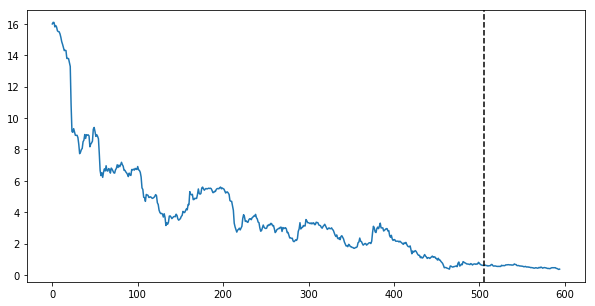

In [561]:
d = test_data.values
plt.figure(figsize=(10,5)) 
plt.plot(d)
split = len(test_data) - int(len(test_data)*test_percent)
plt.axvline(x=split, color='black', linestyle='--')
plt.show()

In [350]:
import random, timeit

start_time = timeit.default_timer()

plt_path = 'plt_qnn_increasing'

if not os.path.exists(plt_path):
    os.makedirs(plt_path)

epochs = 100
gamma = 0.95 #since the reward can be several time steps away, make gamma high
epsilon = 1
batchSize = 100
buffer = 200
replay = []
learning_progress = []
target_net_update_frequency = 30 # every 30 days
tau = 0.001
#stores tuples of (S, A, R, S')
h = 0
#signal = pd.Series(index=market_data.index)
signal = pd.Series(index=np.arange(len(train_data)))
avg_qval_list = []
test_avg_qval_list = []

buff = ReplayBuffer(BUFFER_SIZE)    #Create replay buffer
#TODO add ReplayBuffer support below to train on 1 batch at time instead of 1 sample at time

for i in range(epochs):
    epoch_start_time = timeit.default_timer()

    if i == epochs-1: #the last epoch, use test data set
        #indata = load_data(test=True)
        state, xdata, price_data = init_state(test_data, test=True)
    else:
        state, xdata, price_data = init_state(train_data)
    status = 1
    terminal_state = 0
    #time_step = market_data.index[0] + 64 #when using market_data
    time_step = 14
    #while game still in progress
    avg_qval = 0
    steps = 0
    while(status == 1):
        #We are in state S
        #Let's run our Q function on S to get Q values for all possible actions
        qval = model.predict(state, batch_size=1)
        #avg_qval += np.mean(qval) #TODO mean of qval or max of qval?
        avg_qval += np.max(qval) 

        if (random.random() < epsilon): #choose random action
            action = np.random.randint(0,4) #assumes 4 different actions
        else: #choose best action from Q(s,a) values
            action = (np.argmax(qval))
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action(state, xdata, action, signal, time_step)
        #Observe reward
        reward, bt = get_reward(new_state, time_step, action, price_data, signal, terminal_state)

        #Experience replay storage
        if (len(replay) < buffer): #if buffer not filled, add to it
            replay.append((state, action, reward, new_state))
            #print(time_step, reward, terminal_state)
        else: #if buffer full, overwrite old values
            if (h < (buffer-1)):
                h += 1
            else:
                h = 0
            replay[h] = (state, action, reward, new_state)
            #randomly sample our experience replay memory
            minibatch = random.sample(replay, batchSize)
            X_train = []
            y_train = []
            for memory in minibatch:
                #Get max_Q(S',a)
                old_state, action, reward, new_state = memory
                old_qval = model.predict(old_state, batch_size=1)
                #TODO: use target_model to predict these q values?
                #newQ = target_model.predict(new_state, batch_size=1)
                newQ = model.predict(new_state, batch_size=1)

                maxQ = np.max(newQ)
                y = np.zeros((1,4))
                y[:] = old_qval[:]
                if terminal_state == 0: #non-terminal state
                    update = (reward + (gamma * maxQ))
                else: #terminal state
                    update = reward
                y[0][action] = update
                X_train.append(old_state)
                y_train.append(y.reshape(4,))

            X_train = np.squeeze(np.array(X_train), axis=(1))
            y_train = np.array(y_train)
            model.fit(X_train, y_train, batch_size=batchSize, epochs=1, verbose=0)
            
            if time_step % target_net_update_frequency == 0:
                #print("Reseting Target Weights")
                weights = model.get_weights()
                target_model.set_weights(weights)
            #    target_weights = target_model.get_weights()
            #    for i in xrange(len(weights)):
            #        target_weights[i] = (1 - tau)*target_weights[i] + tau*weights[i]
            #    target_model.set_weights(target_weights)
            
            state = new_state
        steps += 1.0
        if terminal_state == 1: #if reached terminal state, update epoch status
            status = 0
    avg_qval /= steps
    eval_reward, bt = evaluate_Q(test_data, model, price_data, i)
    #TODO save to different folder each time?
    plot_epoch(bt, i, plt_path, test_percent=test_percent)
    learning_progress.append((eval_reward))
    avg_qval_list.append(avg_qval)
    test_avg_qval_list.append(test_avg_qval)
    print("Epoch: %d Reward: %f eps: %f Time: %f (s): Avg Train Q-Val: %f" % 
          (i,eval_reward, epsilon, timeit.default_timer() - epoch_start_time, avg_qval))
    #learning_progress.append((reward))
    if epsilon > 0.1: #decrement epsilon over time
        epsilon -= (1.0/epochs)

#TODO save to different folder each time?
elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

bt = twp.Backtest(pd.Series(data=[x[0,0] for x in xdata]), signal, signalType='shares')
bt.data['delta'] = bt.data['shares'].diff().fillna(0)

print(bt.data)
unique, counts = np.unique(filter(lambda v: v==v, signal.values), return_counts=True)
print(np.asarray((unique, counts)).T)

plt.figure(figsize=(20, 15))
plt.subplot(4,1,1)
bt.plotTrades()
plt.subplot(4,1,2)
bt.pnl.plot(style='x-')
plt.subplot(4,1,3)
plt.plot(learning_progress)
plt.subplot(4, 1, 4)
plt.plot(avg_qval_list)

plt.savefig(plt_path + '/summary'+'.png', bbox_inches='tight', pad_inches=1, dpi=72)
plt.show()

Epoch: 0 Reward: -21607.500000 eps: 1.000000 Time: 115.204980 (s): Avg Train Q-Val: 1.639802
Epoch: 1 Reward: -23712.900000 eps: 0.990000 Time: 165.718333 (s): Avg Train Q-Val: 14.876519
Epoch: 2 Reward: 1894.000000 eps: 0.980000 Time: 177.340021 (s): Avg Train Q-Val: 25.087395
Epoch: 3 Reward: -299.700000 eps: 0.970000 Time: 186.483468 (s): Avg Train Q-Val: 27.580300
Epoch: 4 Reward: 1459.400000 eps: 0.960000 Time: 164.808136 (s): Avg Train Q-Val: 27.436875
Epoch: 5 Reward: -9439.500000 eps: 0.950000 Time: 167.200350 (s): Avg Train Q-Val: 37.584313
Epoch: 6 Reward: -3141.500000 eps: 0.940000 Time: 158.165347 (s): Avg Train Q-Val: 45.370919
Epoch: 7 Reward: 495.000000 eps: 0.930000 Time: 167.435090 (s): Avg Train Q-Val: 39.735374
Epoch: 8 Reward: 10241.500000 eps: 0.920000 Time: 170.484112 (s): Avg Train Q-Val: 41.437825
Epoch: 9 Reward: -4456.500000 eps: 0.910000 Time: 158.884196 (s): Avg Train Q-Val: 52.472400
Epoch: 10 Reward: -12338.000000 eps: 0.900000 Time: 159.016404 (s): Avg Tr

KeyboardInterrupt: 

In [ ]:
#TODO save model here

In [ ]:
#run back test with signal which buys every time, sells every time, does nothing, does one giant buy at beginning at waits?

In [436]:
from keras.layers import Input, Activation
from keras.models import Model


class ActorNetwork(object):
    def __init__(self, sess, state_size, action_size, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE

        K.set_session(sess)

        #Now create the model
        self.model , self.weights, self.state = self.create_actor_network(state_size, action_size)   
        self.target_model, self.target_weights, self.target_state = self.create_actor_network(state_size, action_size) 
        self.action_gradient = tf.placeholder(tf.float32,[None, action_size])
        self.params_grad = tf.gradients(self.model.output, self.weights, -self.action_gradient)
        grads = zip(self.params_grad, self.weights)
        self.optimize = tf.train.AdamOptimizer(LEARNING_RATE).apply_gradients(grads)
        #self.sess.run(tf.initialize_all_variables())

    def train(self, states, action_grads):
        self.sess.run(self.optimize, feed_dict={
            self.state: states,
            self.action_gradient: action_grads,
            K.learning_phase(): 1
        })

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in xrange(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self, state_size, action_dim):
        
        S = Input(shape=[1, state_size])
        L1 = LSTM(64, activation='relu', return_sequences=True,
                       stateful=False)(S)
        #D1 = Dropout(0.5)(L1)

        L2 = LSTM(64, activation='relu', return_sequences=False,
                       stateful=False)(L1)

        #D2 = Dropout(0.5)(L2)
        
        FC = Dense(16, activation='relu', kernel_initializer='he_uniform')(L2)
        O = Dense(action_dim, kernel_initializer='lecun_uniform', activation='linear')(FC) #activation??? tanh?
        #TODO output dimension shouldn't be action_dim, should maybe have two outputs merged, 
        #one for each, possibly two FC's with both relu activations so either 0 or on, 
        #or maybe just one FC with linear acitvation and constrained to -100 to 100 range
        model = Model(inputs=[S], outputs=[O])

        return model, model.trainable_weights, S



In [437]:
#from keras.layers import merge
from keras.layers.merge import concatenate
import keras.backend as K

class CriticNetwork(object):
    def __init__(self, sess, state_size, action_size, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE
        self.action_size = action_size
        
        K.set_session(sess)

        #Now create the model
        self.model, self.action, self.state = self.create_critic_network(state_size, action_size)  
        self.target_model, self.target_action, self.target_state = self.create_critic_network(state_size, action_size)  
        self.action_grads = tf.gradients(self.model.output, self.action)  #GRADIENTS for policy update
        #self.sess.run(tf.initialize_all_variables())

    def gradients(self, states, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.state: states,
            self.action: actions,
            K.learning_phase(): 1
        })[0]

    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in xrange(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self, state_size,action_dim):
        
        
        S = Input(shape=[1, state_size])
        A = Input(shape=[action_dim])
        L1 = LSTM(64, activation='relu', return_sequences=True,
                       stateful=False)(S)
        #D1 = Dropout(0.5)(L1)

        L2 = LSTM(64, activation='relu', return_sequences=False,
                       stateful=False)(L1)

        #D2 = Dropout(0.5)(L2)
        
        m = concatenate([L2, A])
        FC = Dense(16, activation='relu', kernel_initializer='he_uniform')(m)
        O = Dense(action_dim, kernel_initializer='lecun_uniform', activation='linear')(FC) #activation??? tanh?
        model = Model(inputs=[S, A], outputs=[O])
        adam = Adam(lr=self.LEARNING_RATE)
        model.compile(loss='mse', optimizer=adam)

        return model, A, S

In [438]:
from collections import deque
import random

class ReplayBuffer(object):

    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.num_experiences = 0
        self.buffer = deque()

    def getBatch(self, batch_size):
        # Randomly sample batch_size examples
        if self.num_experiences < batch_size:
            return random.sample(self.buffer, self.num_experiences)
        else:
            return random.sample(self.buffer, batch_size)

    def size(self):
        return self.buffer_size

    def add(self, state, action, reward, new_state, done):
        experience = (state, action, reward, new_state, done)
        if self.num_experiences < self.buffer_size:
            self.buffer.append(experience)
            self.num_experiences += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def count(self):
        # if buffer is full, return buffer size
        # otherwise, return experience counter
        return self.num_experiences

    def erase(self):
        self.buffer = deque()
        self.num_experiences = 0


In [499]:
#Take Action
def take_action_ddpg(state, xdata, action, signal, time_step):
    #this should generate a list of trade signals that at evaluation time are fed to the backtester
    #the backtester should get a list of trade signals and a list of price data for the assett
    
    #make necessary adjustments to state and then return it
    time_step += 1
    
    #if the current iteration is the last state ("terminal state") then set terminal_state to 1
    #TODO sell all stocks here?
    #print(xdata.shape)
    if time_step + 1 == xdata.shape[0]:
        state = xdata[time_step-1:time_step, 0:1, :]
        terminal_state = 1
        #stocks_owned = np.sum(signal)
        #signal.loc[time_step] = -stocks_owned
        signal.loc[time_step] = 0

        return state, time_step, signal, terminal_state

    #move the market data window one step forward
    state = xdata[time_step-1:time_step, 0:1, :]
    #take action
    if action > 0:
        signal.loc[time_step] = 100
    elif action < 0:
        signal.loc[time_step] = -100
    else:
        signal.loc[time_step] = 0

    terminal_state = 0

    return state, time_step, signal, terminal_state


def evaluate_DDPG(eval_data, eval_model, price_data, epoch=0):
    #This function is used to evaluate the performance of the system each epoch, without the influence of epsilon and random actions
    signal = pd.Series(index=np.arange(len(eval_data)))
    state, xdata, price_data = init_state(eval_data)
    status = 1
    terminal_state = 0
    time_step = 1
    eval_reward = 0
    while(status == 1):
        #We start in state S
        #Run the Q function on S to get predicted reward values on all the possible actions
        action = eval_model.predict(state)[0, 0]
        
        #Take action, observe new state S'
        new_state, time_step, signal, terminal_state = take_action_ddpg(state, xdata, action, signal, time_step)
        
        #Observe reward
        reward, bt = get_reward(new_state, time_step, action, price_data, signal, terminal_state, eval=True, epoch=epoch)
        eval_reward += reward
        state = new_state
        if terminal_state == 1: #terminal state
            status = 0

    return eval_reward, bt



In [497]:
import tensorflow as tf

#Tensorflow GPU optimization
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

BUFFER_SIZE = 200
BATCH_SIZE = 100
GAMMA = 0.99
TAU = 0.001     #Target Network HyperParameters
LRA = 0.0001    #Learning rate for Actor
LRC = 0.001     #Lerning rate for Critic

action_dim = 1  #num of joints being controlled
state_dim = 7  #num of features in state


actor = ActorNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRA)
critic = CriticNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRC)
sess.run(tf.global_variables_initializer())

In [488]:
actor.modelh = 'plt_ddpg'

if not os.path.exists(plt_path):
    os.makedirs(plt_path)


actor.model.save_weights(plt_path + "/actor.h5")
actor.target_model.save_weights(plt_path + "/actor_target.h5")

critic.model.save_weights(plt_path + "/critic.h5")
critic.target_model.save_weights(plt_path + "/critic_target.h5")


In [494]:
symbol = 'CENX'
#TODO run with other increasing stocks (AAPL, GOOG, GNC, etc.)
#TODO run with NIHD stock (decreasing over time, AMD?, etc) and only 1000 days
#TODO run with cyclycal stock (UNP?, WLK?, CENX?, etc.)
read_convert_data(symbol=symbol) #run once to read indata, resample and convert to pickle (if doesn't exist)

In [495]:
test_percent = 0.15
#max_data = 1825 #5 years (minus leap years)
max_data = 1500 # 3 years

train_data = load_data(test=False, symbol=symbol, max_data=max_data, test_percent=test_percent)
test_data = load_data(test=True, symbol=symbol, max_data=max_data, test_percent=test_percent)

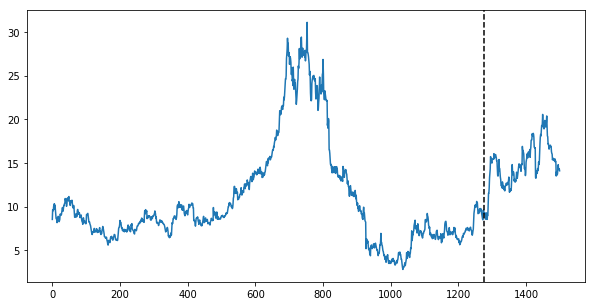

In [496]:
d = test_data['close'].values
plt.figure(figsize=(10,5)) 
plt.plot(d)
split = len(test_data) - int(len(test_data)*test_percent)
plt.axvline(x=split, color='black', linestyle='--')
plt.show()

In [498]:
EXPLORE = 150.0
init_epsilon = 0.5
epochs = 250


In [500]:
signal = pd.Series(index=np.arange(len(train_data)))
learning_progress = []

start_time = timeit.default_timer()

    
buff = ReplayBuffer(BUFFER_SIZE)    #Create replay buffer
epsilon = init_epsilon

for i in range(epochs): #change to while not done as above

    
    epoch_start_time = timeit.default_timer()

    if i == epochs-1: #the last epoch, use test data set
        state, xdata, price_data = init_state(test_data, test=True)
    else:
        state, xdata, price_data = init_state(train_data)
    status = 1
    terminal_state = 0
    time_step = 14
    total_reward = 0
    
    while(status == 1):
        
        action = np.zeros([1,action_dim])
        #noise_t = np.zeros([1,action_dim])
        

        if np.random.random() > epsilon:
            action = actor.model.predict(state)*1 #rescale
        else:
            action = np.random.uniform(-100,100, size=(1,1))
            
            
        #Take action, observe new state S'
        #TODO change up take_action to take 1 value that is pos or neg
        new_state, time_step, signal, terminal_state = take_action_ddpg(state, xdata, action[0, 0], signal, time_step)
        #Observe reward
        reward, bt = get_reward(new_state, time_step, action, price_data, signal, terminal_state)
        total_reward += reward

        buff.add(state, action[0], reward, new_state, terminal_state)      #Add replay buffer

        #Do the batch update
        batch = buff.getBatch(BATCH_SIZE)
        states = np.asarray([e[0] for e in batch])[:, 0, :, :]
        actions = np.asarray([e[1] for e in batch])
        rewards = np.asarray([e[2] for e in batch])
        new_states = np.asarray([e[3] for e in batch])[:, 0, :, :]
        dones = np.asarray([e[4] for e in batch])
        y_t = np.asarray([e[1] for e in batch])
        
        target_q_values = critic.target_model.predict([new_states, actor.target_model.predict(new_states)])  

        for k in range(len(batch)):
            if dones[k]:
                y_t[k] = rewards[k]
            else:
                y_t[k] = rewards[k] + GAMMA*target_q_values[k]

        critic.model.train_on_batch([states,actions], y_t) 
        a_for_grad = actor.model.predict(states)
        grads = critic.gradients(states, a_for_grad)
        actor.train(states, grads)
        actor.target_train()
        critic.target_train()

        state = new_state

        if terminal_state == 1: #if reached terminal state, update epoch status
            status = 0

    #if np.mod(i, 3) == 0:
    #    if (train_indicator):
    #        actor.model.save_weights("actormodel.h5", overwrite=True)
    #        critic.model.save_weights("criticmodel.h5", overwrite=True)

    
    
    eval_reward, bt = evaluate_DDPG(test_data, actor.model, price_data, i)
    plot_epoch(bt, i, plt_path, test_percent=test_percent)
    learning_progress.append((eval_reward))
    print("Epoch: %s Total Reward: %f Eval Reward: %f eps: %f Time: %f (s)" % 
          (i, total_reward, eval_reward, epsilon, timeit.default_timer() - epoch_start_time))
    
    epsilon -= init_epsilon / EXPLORE
    #if epsilon < 0.1:
    #    epsilon = 0.1


#TODO other end of game stuffelapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

bt = twp.Backtest(pd.Series(data=[x[0,0] for x in xdata]), signal, signalType='shares')
bt.data['delta'] = bt.data['shares'].diff().fillna(0)

print(bt.data)
unique, counts = np.unique(filter(lambda v: v==v, signal.values), return_counts=True)
print(np.asarray((unique, counts)).T)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
bt.plotTrades()
plt.subplot(3,1,2)
bt.pnl.plot(style='x-')
plt.subplot(3,1,3)
plt.plot(learning_progress)

plt.savefig(plt_path + '/summary'+'.png', bbox_inches='tight', pad_inches=1, dpi=72)
plt.show()


Epoch: 0 Total Reward: -1636.000000 Eval Reward: 459.000000 eps: 0.500000 Time: 123.321589 (s)
Epoch: 1 Total Reward: -764.640000 Eval Reward: 459.000000 eps: 0.496667 Time: 79.988645 (s)
Epoch: 2 Total Reward: -1288.500000 Eval Reward: 459.000000 eps: 0.493333 Time: 79.801341 (s)
Epoch: 3 Total Reward: 1614.700000 Eval Reward: 459.000000 eps: 0.490000 Time: 81.225581 (s)
Epoch: 4 Total Reward: 986.600000 Eval Reward: 459.000000 eps: 0.486667 Time: 81.730055 (s)
Epoch: 5 Total Reward: 2677.880000 Eval Reward: 459.000000 eps: 0.483333 Time: 83.423892 (s)
Epoch: 6 Total Reward: -454.400000 Eval Reward: 459.000000 eps: 0.480000 Time: 81.249903 (s)
Epoch: 7 Total Reward: -312.530000 Eval Reward: 713.000000 eps: 0.476667 Time: 81.269494 (s)
Epoch: 8 Total Reward: 1325.690000 Eval Reward: -331.000000 eps: 0.473333 Time: 81.939273 (s)
Epoch: 9 Total Reward: 118.640000 Eval Reward: -459.000000 eps: 0.470000 Time: 81.458334 (s)
Epoch: 10 Total Reward: 512.590000 Eval Reward: 2113.200000 eps: 0.

Epoch: 87 Total Reward: -167.900000 Eval Reward: -2915.000000 eps: 0.210000 Time: 71.027025 (s)
Epoch: 88 Total Reward: -462.500000 Eval Reward: -1932.000000 eps: 0.206667 Time: 72.046801 (s)
Epoch: 89 Total Reward: 340.830000 Eval Reward: -2910.000000 eps: 0.203333 Time: 72.392251 (s)
Epoch: 90 Total Reward: 325.780000 Eval Reward: -3302.000000 eps: 0.200000 Time: 71.527282 (s)
Epoch: 91 Total Reward: -1031.670000 Eval Reward: -1419.980000 eps: 0.196667 Time: 71.810633 (s)
Epoch: 92 Total Reward: 269.010000 Eval Reward: -1251.980000 eps: 0.193333 Time: 72.101305 (s)
Epoch: 93 Total Reward: 223.500000 Eval Reward: -1387.980000 eps: 0.190000 Time: 71.237471 (s)
Epoch: 94 Total Reward: 1016.800000 Eval Reward: -959.980000 eps: 0.186667 Time: 71.907361 (s)
Epoch: 95 Total Reward: 193.000000 Eval Reward: -1367.980000 eps: 0.183333 Time: 72.234397 (s)
Epoch: 96 Total Reward: -232.980000 Eval Reward: -1507.980000 eps: 0.180000 Time: 71.409321 (s)
Epoch: 97 Total Reward: 475.500000 Eval Rewar

Epoch: 173 Total Reward: 233.000000 Eval Reward: 1695.000000 eps: -0.076667 Time: 88.825527 (s)
Epoch: 174 Total Reward: -226.500000 Eval Reward: 991.000000 eps: -0.080000 Time: 83.517928 (s)
Epoch: 175 Total Reward: 361.500000 Eval Reward: 1523.000000 eps: -0.083333 Time: 83.803946 (s)
Epoch: 176 Total Reward: 220.000000 Eval Reward: 623.000000 eps: -0.086667 Time: 83.539168 (s)
Epoch: 177 Total Reward: -183.500000 Eval Reward: -1317.220000 eps: -0.090000 Time: 83.755758 (s)
Epoch: 178 Total Reward: -7.380000 Eval Reward: -1138.180000 eps: -0.093333 Time: 83.579735 (s)
Epoch: 179 Total Reward: 190.950000 Eval Reward: 18.120000 eps: -0.096667 Time: 84.010418 (s)
Epoch: 180 Total Reward: -2.510000 Eval Reward: 59.320000 eps: -0.100000 Time: 83.842933 (s)
Epoch: 181 Total Reward: -12.520000 Eval Reward: 736.020000 eps: -0.103333 Time: 84.748375 (s)
Epoch: 182 Total Reward: -78.500000 Eval Reward: 140.000000 eps: -0.106667 Time: 83.928292 (s)
Epoch: 183 Total Reward: 97.500000 Eval Reward

Exception KeyboardInterrupt: KeyboardInterrupt() in <bound method Session.__del__ of <tensorflow.python.client.session.Session object at 0x7fd0da9d7b90>> ignored


KeyboardInterrupt: 

In [ ]:
#TODO fixup for stock trading

# A2C(Advantage Actor-Critic) agent for the Cartpole
class A2CAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        if self.load_model:
            self.actor.load_weights("./save_model/cartpole_actor.h5")
            self.critic.load_weights("./save_model/cartpole_critic.h5")
            
    def build_model(self):
        #TODO build one model with state input and 2 outputs (policy [size of action space] and value [size 1])

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='he_uniform'))
        actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        #TODO update to train the one model
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

#TODO change below to work with my code
#TODO make it use target network?
#TODO make it use experience replay?
if __name__ == "__main__":
    # In case of CartPole-v1, maximum length of episode is 500
    env = gym.make('CartPole-v1')
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # make A2C agent
    agent = A2CAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -100

            agent.train_model(state, action, reward, next_state, done)

            score += reward
            state = next_state

            if done:
                # every episode, plot the play time
                score = score if score == 500.0 else score + 100
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./save_graph/cartpole_a2c.png")
                print("episode:", e, "  score:", score)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    sys.exit()

        # save the model
        if e % 50 == 0:
            agent.actor.save_weights("./save_model/cartpole_actor.h5")
            agent.critic.save_weights("./save_model/cartpole_critic.h5")